In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import glob, cv2, os, sys

from tqdm import tqdm


float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Data

### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Take a look

In [3]:
# get fold_1 image and label files path

images = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/image/*.png')
labels = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/label/*.png')

images.sort(), labels.sort()

(None, None)

In [4]:
images[0], labels[0]

('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/image/0001.png',
 '/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/label/0001.png')

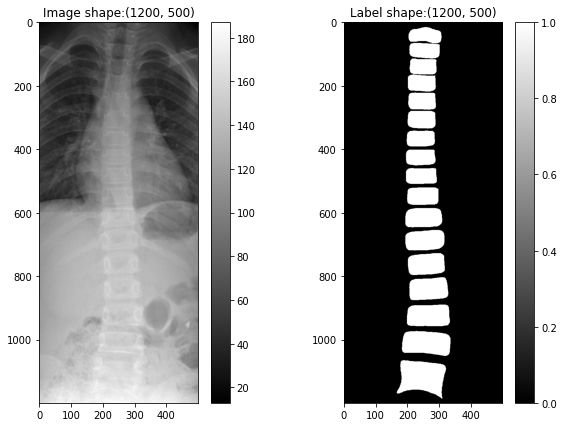

In [5]:
plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
img = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap = 'gray')
plt.title('Image shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
label = cv2.imread(labels[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(label / 255., cmap = 'gray')
plt.title('Label shape:{}'.format(label.shape))
plt.colorbar()


# U-Net Architecture

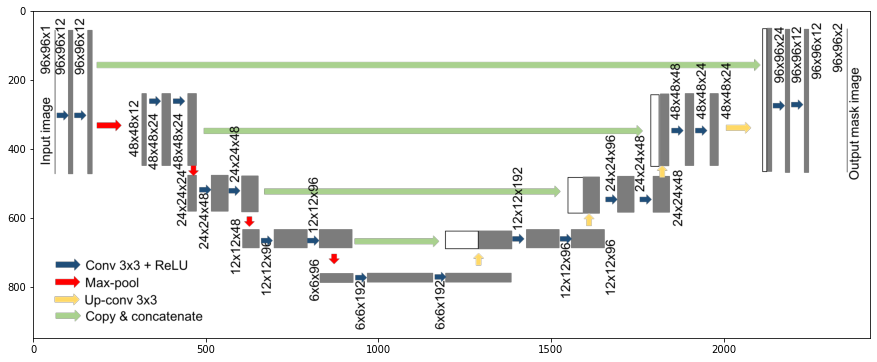

In [6]:
plt.figure(figsize = (15, 15))
img = plt.imread('http://jidan.sinkpoint.com/images/True_Unet_MRI_deco.png')
plt.imshow(img)

# Part1. Build a simple model first

In [7]:
"""
1.PyTorch中的nn.Module是構成模型的最基礎block，可以自行客製化。
2.nn.Module可以包含另一個nn.Module
3.nn.Module享有PyTorch的Autograd機制
4.每個nn.Module都有一個parameters() function, return a list of all trainable parameters
5.Module中的trainable parameters必須被事先定義在constructor內，否則不會存在於Computation graph中
"""

'''
aW+b

input: (1x2)
hidden_layer: (2x2)
output : (1x2) x (2x2) = activation((1x2))
'''

class MyModel(nn.Module):
  def __init__(self, dim = 2 , output_dim = 2):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(size = (dim, output_dim)))
    self.bias = nn.Parameter(torch.randn(output_dim))

    #or in this why : self.linear = nn.Linear(in_features = dim, out_features = output_dim, bias = True)

    self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    logit = x @ self.weights + self.bias # (1,2)
    y = self.softmax(logit)

    # Same as : y = F.softmax(logit, dim = 1)
    return y

In [8]:
myModel = MyModel(dim = 2, output_dim = 2)

# myModel.forward(x)
pred = myModel(torch.randn(1, 2))

'''
1. detach() : 把node從computation graph移除 -> Tensor永遠不會計算gradient
2. cpu() : 從CUDA(GPU) memory移至cpu memory中存放
3. numpy(): 轉成numpy array
'''
pred = pred.detach().cpu().numpy()
print('Output shape: %s\n %s' %(pred.shape, pred)) 

Output shape: (1, 2)
 [[0.95 0.05]]


In [9]:
print('List of parameters : \n{}\n'.format(list(myModel.parameters())))

List of parameters : 
[Parameter containing:
tensor([[ 0.1210,  0.6469],
        [ 0.9674, -0.6472]], requires_grad=True), Parameter containing:
tensor([-0.4870, -1.3670], requires_grad=True)]



### nn.Module v.s. nn.functionals

In [10]:
data_x = torch.randn(size = (1, 2))

softmax1 = nn.Softmax(dim = 1)
softmax2 = F.softmax

print('nn.Moudle.Softmax : {}'.format(softmax1(data_x)))
print('nn.functional.softmax : {}'.format(softmax2(data_x, dim=1)))

nn.Moudle.Softmax : tensor([[0.8867, 0.1133]])
nn.functional.softmax : tensor([[0.8867, 0.1133]])


In [11]:
'''
最大的不同在於：nn.functionals.xxx只有"計算功能"。
幾乎所有nn.Module.xxx的forward都是以nn.functional.xxx實作，weight都是用nn.Parameter
nn.Module擁有將parameter放入computation graph中利用Autograd機制進行訓練參數的功能

如何選擇？Statefulness

'''

data_x = torch.randn(size = (2, 2))
dim = 2
output_dim = 1

#宣告weights和bias給linear2使用
#linear2沒有parameters()這個function
weights = nn.Parameter(torch.randn(size = (output_dim, dim)))
bias = nn.Parameter(torch.randn(output_dim))
linear2 = F.linear

#nn.Linear的constructor會自動創建nn.Parameter和bias
#linear2有parameters()這個function
linear1 = nn.Linear(dim, output_dim)

print('nn.Moudle.Linear : {}'.format(linear1(data_x)))
print('nn.functional.linear : {}'.format(linear2(data_x, weights, bias)))

nn.Moudle.Linear : tensor([[0.7180],
        [0.6125]], grad_fn=<AddmmBackward>)
nn.functional.linear : tensor([[-0.0444],
        [ 1.5670]], grad_fn=<AddmmBackward>)


### nn.Parameter

In [12]:
'''
PyTorch中最重要的一個Class，沒有他其他nn.Module什麼都不是。
前面所看到的parameters() function，回傳的就是Module中所有nn.Parameter object。

nn.Parameter的一些重要特性：
1.繼承至Tensor class，其本質也就只是一個Tensor(高維的矩陣)
2.當被包含在某個Module的atrribute中，會自動被加入該Module的parameters list
3.可以把普通的Tensor轉成trainable的parameter
'''

class Net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = torch.randn(size = (3, 3, 3))
  def forward(self):
    return self.tensor

net1 = Net1()
print('List of parameters: {}\n'.format(list(net1.parameters())))


class Net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = nn.Parameter(torch.randn(size = (3, 3, 3)))
  def forward(self):
    return self.tensor

net2 = Net2()
print('List of parameters: {}'.format(list(net2.parameters())))

List of parameters: []

List of parameters: [Parameter containing:
tensor([[[-0.8986, -0.2783, -0.2948],
         [-0.6496,  1.0195,  0.8832],
         [ 0.4994, -1.2599, -0.7358]],

        [[-0.0914, -2.3794,  0.5600],
         [-0.3824,  1.2736,  0.5764],
         [-1.5352,  1.1457, -0.1089]],

        [[ 0.2255, -0.8630,  0.0409],
         [ 0.6143, -1.2841, -0.3765],
         [ 0.3779,  1.0910,  0.6985]]], requires_grad=True)]


In [13]:
'''
Net1包含於Net2，則Net1的parameter會自動添加入Net2的parameter list中。
'''

class Net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = nn.Parameter(torch.randn(size = (3, 3, 3)))
  def forward(self):
    return self.tensor

myNet = Net1()
print('List of parameters: {}\n'.format(list(myNet.parameters())))

class Net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.tensor = nn.Parameter(torch.randn(1))
    self.net = Net1()
  def forward(self):
    return self.tensor

myNet = Net2()
print('List of parameters: {}'.format(list(myNet.parameters())))


List of parameters: [Parameter containing:
tensor([[[ 1.5616,  0.2879, -1.0090],
         [-0.5347, -0.6546, -1.4736],
         [-0.7922,  0.4631,  0.0387]],

        [[-0.3994, -1.1529,  0.8985],
         [-0.7352, -1.4652, -1.2333],
         [ 1.2060, -0.4775, -0.2540]],

        [[ 0.2239,  0.4630,  1.4655],
         [-0.6792, -2.1606,  2.6479],
         [-0.4738,  1.5489,  0.3614]]], requires_grad=True)]

List of parameters: [Parameter containing:
tensor([-0.1350], requires_grad=True), Parameter containing:
tensor([[[ 0.1017,  1.2820, -0.5010],
         [ 0.5010,  0.9324,  2.2741],
         [-0.3128, -0.0873, -1.1327]],

        [[ 0.9324,  0.9557, -0.2167],
         [-0.2343,  0.5835, -0.0305],
         [-0.4763,  0.7807, -0.9378]],

        [[-0.7043,  0.1319, -0.1405],
         [-1.0761, -1.7445, -0.3653],
         [-1.9008,  0.1276, -1.0783]]], requires_grad=True)]


# Part2.Simple U-Net model

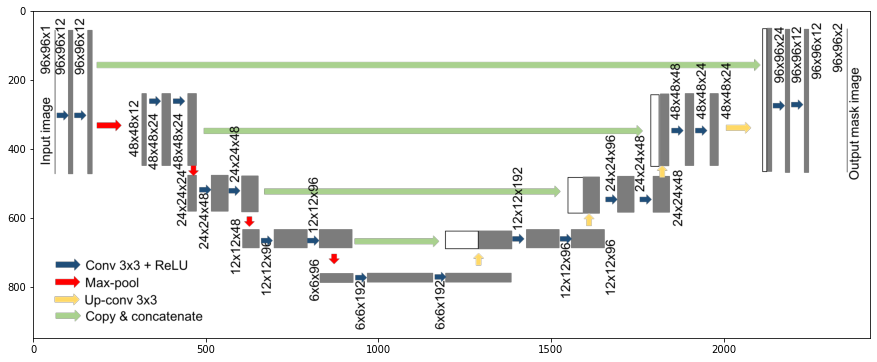

In [14]:
plt.figure(figsize = (15, 15))
img = plt.imread('http://jidan.sinkpoint.com/images/True_Unet_MRI_deco.png')
plt.imshow(img)

In [15]:
class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)

In [16]:
class conv3x3_bn_relu(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding = 1):
    super().__init__()

    self.sequence = nn.Sequential(
      nn.Conv2d(inplanes, kernels, kernel_size = 3, stride = stride, padding = padding),
      nn.BatchNorm2d(num_features = kernels),
      nn.ReLU(inplace = True)  
    )

  def forward(self, x):
    
    return self.sequence(x)

In [17]:
class down(nn.Module):
  def __init__(self, inplanes, kernels, stride, padding = 1, pooling = True):
    super().__init__()
    self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
        SE_Block(kernels)
    )
    self.max_pooling = nn.MaxPool2d(2) if pooling else nn.Identity()
  def forward(self, x):
    return self.conv(self.max_pooling(x))

In [18]:
class up(nn.Module):
  def __init__(self, inplanes, kernels, stride = 1, padding = 1, bilinear = True):
    super().__init__()
    if bilinear :
      self.up = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners = True)
      self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes + inplanes // 2, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
      ) 
      # self.conv = nn.ModuleList([
      #   conv3x3_bn_relu(inplanes + inplanes // 2, kernels, stride, padding),
      #   conv3x3_bn_relu(kernels, kernels, stride, padding),                            
      # ])
    else:
      self.up = nn.ConvTranspose2d(inplanes, inplanes//2, kerenls_size = 2, stride = stride)
      
      self.conv = nn.Sequential(
        conv3x3_bn_relu(inplanes, kernels, stride, padding),
        conv3x3_bn_relu(kernels, kernels, stride, padding),
      ) 
  def forward(self, x1, x2):
    x2 = self.up(x2)
    #print(x2.shape)
    return self.conv(torch.cat([x1, x2], dim = 1))

In [19]:
class Unet(nn.Module):
  def __init__(self, n_channel = 1, n_class = 1, bilinear = True):
    super().__init__()
    self.down1 = down(n_channel, 12, 1, pooling = False)
    self.down2 = down(12, 24, 1)
    self.down3 = down(24, 48, 1)
    self.down4 = down(48, 96, 1)
    self.down5 = down(96, 192, 1)
    self.up1 = up(96*2, 96, 1, bilinear = bilinear)
    self.up2 = up(48*2, 48, 1, bilinear = bilinear)
    self.up3 = up(24*2, 24, 1, bilinear = bilinear)
    self.up4 = up(12*2, 12, 1, bilinear = bilinear)
    self.out = nn.Conv2d(12, n_class, 3, 1, padding = 1)
  def forward(self, x):
    x1 = self.down1(x)
    x2 = self.down2(x1)
    x3 = self.down3(x2)
    x4 = self.down4(x3)
    x5 = self.down5(x4)
    x = self.up1(x4, x5)
    x = self.up2(x3, x)
    x = self.up3(x2, x)
    x = self.up4(x1, x)
    logit = self.out(x)
    return logit

### nn.Sequential v.s. nn.ModuleList

In [20]:
'''
nn.Sequential: 屬於nn.Module class，可以把一連串的nn.Module彼此chain在一起。無法改變這些Module的執行順序
nn.ModuleList: 類似python內建的list，只是裡面是裝nn.Module。同list可以用indexing的方式決定使用哪個nn.Module
'''
class sequentialNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = nn.Sequential(
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    )

  def forward(self, x):
    return self.modules(x)


class moduleListNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = nn.ModuleList([
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    ])

  def forward(self, x):
    for i in range(len(self.modules)):
      x = self.modules[i](x)
    return x

In [21]:
'''
nn.ModuleList與python中list唯一的不同在於，nn.ModuleList才會將nn.Module中的parameter註冊到Module的parameters list。一般的list則否
'''

class moduleListNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = nn.ModuleList([
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    ])

  def forward(self, x):
    for m in self.modules:
      x = m(x)
    return x

class standardListNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.modules = [
        nn.Linear(10, 10),
        nn.Linear(10, 2)
    ]

  def forward(self, x):
    for m in self.modules:
      x = m(x)
    return x

mlNet = moduleListNet()
slNet = standardListNet()
print('List of parameters: {}\n'.format(list(mlNet.parameters())))
print('List of parameters: {}'.format(list(slNet.parameters())))

List of parameters: [Parameter containing:
tensor([[ 0.0648,  0.0236, -0.2865, -0.1276,  0.0207, -0.1123, -0.3070, -0.1012,
         -0.1512, -0.0114],
        [-0.2350,  0.2574,  0.2385, -0.0558, -0.0541,  0.0691, -0.2477, -0.1217,
          0.2525, -0.1496],
        [ 0.1794,  0.1466,  0.2545, -0.2650, -0.0206,  0.0023, -0.2580,  0.1254,
         -0.1254, -0.2831],
        [-0.1992, -0.0879, -0.1223, -0.2048, -0.2379, -0.2516,  0.1804, -0.1080,
         -0.0387,  0.2074],
        [ 0.2053,  0.2015, -0.2788,  0.1301, -0.1751, -0.0799,  0.1812,  0.2261,
         -0.1550,  0.0362],
        [-0.0950,  0.0406,  0.2251,  0.2914, -0.2248,  0.3080,  0.1626,  0.0096,
          0.1762, -0.0477],
        [ 0.2828, -0.2630,  0.1834, -0.1039,  0.0989,  0.2654,  0.0320,  0.2718,
         -0.0099,  0.1320],
        [ 0.1067,  0.0742,  0.2412,  0.0191,  0.3033,  0.0263, -0.0287, -0.1148,
         -0.0615, -0.1138],
        [-0.2903, -0.2124,  0.2322,  0.2731,  0.2209, -0.0725,  0.0724, -0.1361,
    

# Part3. Dataset & Dataloader

### Dataset

#### Example 1

In [22]:
'''
torchvision有提供很多跟影像相關的Dataset class
只不過這邊我們學怎麼根據自己的資料自定義自己的Dataset class :)
'''

from torch.utils.data import Dataset

In [23]:
images[0], labels[0]

('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/image/0001.png',
 '/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/label/0001.png')

In [24]:
class SimpleImageDataset(Dataset):
  def __init__(self, images, labels):
    super().__init__()
    self.images = images
    self.labels = labels

  # 讓這個class可以用indexing的方式取東西
  def __getitem__(self, index):

    # get path
    img = self.images[index]
    label = self.labels[index]

    # read image
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

    # 增加channel這個維度
    img = img[:,:,np.newaxis]
    label = label[:,:,np.newaxis]

    return img, label
  
  def __len__(self):
    #有多少筆數的資料
    return len(self.images)

In [25]:
mDataset = SimpleImageDataset(images, labels)
len(images) == len(mDataset)

True

In [26]:
img, label = mDataset[15]

In [27]:
print(img.shape)
print(img.squeeze(2)) # 去除第二維度中維數為1的維度


(1200, 500, 1)
[[ 38  36  36 ...  30  30  30]
 [ 38  40  40 ...  30  30  30]
 [ 38  37  37 ...  32  32  32]
 ...
 [210 204 206 ... 164 165 167]
 [207 209 205 ... 158 164 163]
 [213 212 210 ... 163 168 164]]


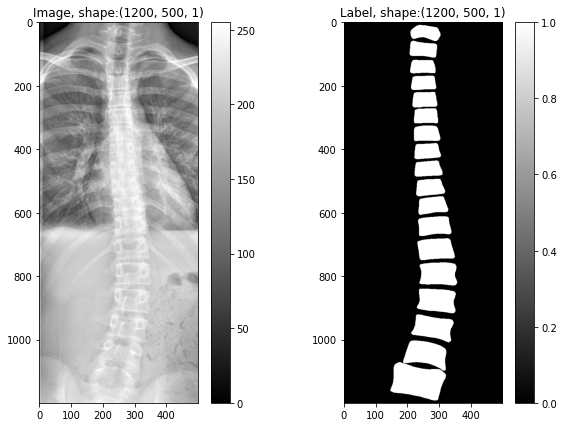

In [28]:
plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(2), cmap = 'gray')
plt.title('Image, shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
plt.imshow(label.squeeze(2) / 255., cmap = 'gray')
plt.title('Label, shape:{}'.format(label.shape))
plt.colorbar()


#### Example 2

In [29]:
import pandas as pd

In [30]:
df = pd.read_csv('/content/drive/My Drive/vertebral/example.csv')

FileNotFoundError: ignored

In [31]:
df.head()

NameError: ignored

In [ ]:
df.iloc[:,2:]

In [ ]:
titanic_data = df.iloc[:,2:].to_numpy()
titanic_labels = df['Survived'].tolist()

In [ ]:
class TitanicDataset(Dataset):
  def __init__(self, data, labels):
    super().__init__()
    self.data = data
    self.labels = labels
  def __getitem__(self, index):
    
    data = self.data[index]
    labels = self.labels[index]

    '''
      Data preporcessing here
    '''

    return data, labels
  
  def __len__(self):
    #有多少筆數的資料
    return len(self.data)

In [ ]:
titanicDataset = TitanicDataset(titanic_data, titanic_labels)
titanicDataset[0]

### Dataloader

In [32]:
'''
Dataloader可以視為Dataset的迭代器，主要包含兩個東東：
1.Dataset
2.Sampler -> 產生index


幾個比較重要的參數:
1.batch_size: 一次load多少份資料
2.shuffle: 每次把所有資料都load過一遍之後，是否要不要shuffle新一輪的順序。
shuffle = True -> default RandomSampler; shuffle = False -> default SequentialSampler
3.num_workers: 執行緒數量，加快資料的載入
4.pin_memory: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
5.drop_last: 最後一個batch的資料數量若小於batch_size，是否略過
'''

from torch.utils.data import DataLoader

In [33]:
mDataloader = DataLoader(dataset = mDataset, batch_size = 10, shuffle = True, num_workers = 4, drop_last = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [34]:
mDataloader_iter = iter(mDataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [35]:
data = next(mDataloader_iter)
print(data[0].shape, data[1].shape) # (b, h, w, c)

torch.Size([10, 1200, 500, 1]) torch.Size([10, 1200, 500, 1])


# Part4. Training pipeline

### Augmentation

In [36]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 3.4 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [37]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2

In [38]:
def get_simple_training_augmetation():
  aug = [
         albu.Flip(p = 0.5),
         albu.ShiftScaleRotate(shift_limit = 0.1, rotate_limit= 30, border_mode=cv2.BORDER_CONSTANT, p = 0.8),
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)
  ]
  return albu.Compose(aug)

def get_validation_augmentation():
  aug = [
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)
         
  ]
  return albu.Compose(aug)

In [39]:
class AugmentedImageDataset(Dataset):
  def __init__(self, images, labels, augmentation = None):
    super().__init__()
    self.images = images
    self.labels = labels
    self.augmentation = augmentation
  def __getitem__(self, index):

    # get path
    img = self.images[index]
    label = self.labels[index]

    # read image
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    label = cv2.imread(label, cv2.IMREAD_GRAYSCALE)

    # 增加channel這個維度
    img = img[:,:,np.newaxis]
    label = label[:,:,np.newaxis]

    # Augmentation
    if(self.augmentation):
      sampled = self.augmentation(image = img, mask = label)
      img = sampled['image']
      label = sampled['mask']


    return torch.div(img, 255), torch.div(label, 255)
  
  def __len__(self):
    #有多少筆數的資料
    return len(self.images)

In [40]:
mDataset = AugmentedImageDataset(images, labels, augmentation = get_simple_training_augmetation())

In [ ]:
img, label = mDataset[0]

img.shape, label.shape

(torch.Size([1, 1216, 512]), torch.Size([1, 1216, 512]))

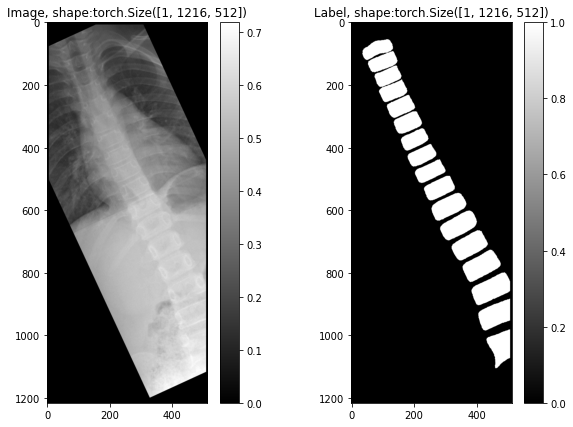

In [ ]:
plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(0), cmap = 'gray')
plt.title('Image, shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
plt.imshow(label.squeeze(0), cmap = 'gray')
plt.title('Label, shape:{}'.format(label.shape))
plt.colorbar()


In [ ]:
def get_complex_training_augmetation():
  aug = [
         albu.Flip(p = 0.5),
         albu.ShiftScaleRotate(shift_limit = 0.1, rotate_limit= 30, border_mode=cv2.BORDER_CONSTANT, p = 0.8),

         albu.OneOf([
            albu.ElasticTransform(p = 0.8),
            albu.GridDistortion(p = 0.5)
         ], p = 0.8),

        albu.OneOf([
           albu.IAAAdditiveGaussianNoise(p=0.9),
           albu.GaussNoise(p=0.6),
       ], p = 0.8),
               
         albu.PadIfNeeded(1216, 512, always_apply = True, border_mode=cv2.BORDER_CONSTANT),
         ToTensorV2(transpose_mask = True)
  ]
  return albu.Compose(aug)

In [ ]:
mDataset = AugmentedImageDataset(images, labels, augmentation = get_complex_training_augmetation())

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


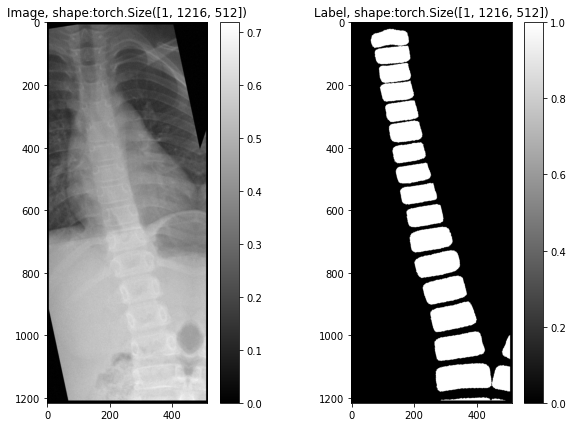

In [ ]:
img, label = mDataset[0]

plt.figure(figsize=(10, 7))

#plot images[0]
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(0), cmap = 'gray')
plt.title('Image, shape:{}'.format(img.shape))
plt.colorbar()

#plot labels[0]
plt.subplot(1, 2, 2)
plt.imshow(label.squeeze(0), cmap = 'gray')
plt.title('Label, shape:{}'.format(label.shape))
plt.colorbar()


### Training Setting

In [ ]:
class Dice(nn.Module):
  def __init__(self, eps = 1e-7, threshold = 0.5):
    super().__init__()
    self.eps = eps
    self.threshold = threshold
    self.activation = torch.sigmoid

  @property
  def __name__(self):
    return 'Dice'

  def _threshold(self, x):
    return (x > self.threshold).type(x.dtype)

  def forward(self, y_pr, y_gt):

    y_pr = self.activation(y_pr)
    y_pr = self._threshold(y_pr)

    tp = torch.sum(y_gt * y_pr)
    fp = torch.sum(y_pr) - tp
    fn = torch.sum(y_gt) - tp

    score = torch.div((2 * tp + self.eps), (2 * tp +  fn + fp + self.eps))
    return score  

class AverageValueMeter(object): #紀錄training所有的loss跟matrix
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n = 1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 1:
            self.mean = 0.0 + self.sum 
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

def to_string(logs):
  str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
  s = ', '.join(str_logs)
  return s

In [ ]:
epochs = 60
lr = 5e-5
weight_decay = 1e-5
kfold = 3
save_path = '/content/drive/My Drive/新生訓練/20210720/vertebral/weight'

bce_loss = nn.BCEWithLogitsLoss() #WithLogits: 計算loss的input沒有經過sigmoid, normalize <-> nn.BCELoss

metric = Dice()
optimizer = torch.optim.Adam

device = 'cuda' if torch.cuda.is_available else 'cpu' #cuda->GPU

batch_size = 8
num_workers = 2
shuffle = True
drop_last = True
pin_memory = True


### Training & Validation

In [ ]:
def get_train_valid_data(fold):# 決定哪些fold要train那些要test

    train_images = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f0{}/image/*.png'.format((fold+1)%3+1)) +\
                  glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f0{}/image/*.png'.format((fold+2)%3+1))

    train_labels = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f0{}/label/*.png'.format((fold+1)%3+1)) +\
                  glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f0{}/label/*.png'.format((fold+2)%3+1))

    valid_images = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f0{}/image/*.png'.format(fold%3+1))
    valid_labels = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f0{}/label/*.png'.format(fold%3+1))
    

    train_images.sort()
    train_labels.sort()
    valid_images.sort()
    valid_labels.sort()

    return (train_images, train_labels), (valid_images, valid_labels)

In [ ]:
k_fold_best = [0] * kfold


for fold in range(kfold):

  (train_images, train_labels), (valid_images, valid_labels) = get_train_valid_data(fold)
  
  # 讀資料, loader
  train_dataset = AugmentedImageDataset(train_images, train_labels, get_complex_training_augmetation())
  valid_dataset = AugmentedImageDataset(valid_images, valid_labels, get_validation_augmentation())
  train_loader = DataLoader(train_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)
  valid_loader = DataLoader(valid_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)

  seg_model = Unet(n_channel = 1)
  opt = optimizer(seg_model.parameters(), lr = lr, weight_decay = weight_decay) # seg_model.parameters(): update model parameter, return learnable, trainable parameter

  seg_model.to(device)
  metric.to(device)

  model_name = os.path.join(save_path, str(fold+1), 'Unet.h5')

  max_score = 0

  # epoch: 把所有資料跑過一遍
  for epoch in range(epochs): # 每個fold會跑60個epoch
    print('Epoch: %d' %(epoch+1))

    #training phase
    seg_model.train() #!!!!非常重要!!!!
    
    train_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(train_loader, desc = 'Train', file = sys.stdout) as iterator: # 會跑training的進度條
      for imgs, gts in iterator:
        
        imgs = imgs.to(device, dtype = torch.float)# input記得要跟model在同一個device上，否則一個model在momery，另一個在gpu的memory是無法training的
        gts = gts.to(device, dtype = torch.float)
        preds = seg_model(imgs)
        loss = bce_loss(preds, gts)

        #計算gradient
        loss.backward()
        #根據gradient和lr等等更新網路權重
        opt.step()
        #記得清零，否則會保留上一個batch的grad
        opt.zero_grad()

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        train_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        train_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(train_logs))


    #validation phase
    seg_model.eval() #!!!!非常重要!!!!
    
    val_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(valid_loader, desc = 'Valid', file = sys.stdout) as iterator:
      for imgs, gts in iterator:
        with torch.no_grad(): #!!!不算gradient!!! 沒寫其實也沒有關係，只是會不斷的累積gradient直到記憶體爆炸
        
          imgs = imgs.to(device, dtype = torch.float)
          gts = gts.to(device, dtype = torch.float)

          preds = seg_model(imgs)
          loss = bce_loss(preds, gts)

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        val_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        val_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(val_logs))


    if max_score < val_logs['Dice']:
      max_score = val_logs['Dice'];
      k_fold_best[fold] = val_logs['Dice']

      torch.save(seg_model.state_dict(), model_name) # 前者model parameter(key: weight名稱。), 後者是存的地方
      print('Model Save !!!!')

print('\n')
print('K-Fold average Dice : %0.4f' %(sum(k_fold_best) / len(k_fold_best)))



/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch: 1
Train:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Valid: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, CrossEntropy - 0.6748, Dice - 1.694e-13]
Model Save !!!!
Epoch: 2
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, CrossEntropy - 0.671, Dice - 1.67e-13]
Epoch: 3
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, CrossEntropy - 0.6604, Dice - 1.684e-13]
Epoch: 4
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s, CrossEntropy - 0.6413, Dice - 1.675e-13]
Epoch: 5
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, CrossEntropy - 0.6207, Dice - 1.677e-13]
Epoch: 6
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s, CrossEntropy - 0.614, Dice - 1.645e-13]
Epoch: 7
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s, CrossEntropy - 0.6516, Dice - 0.4437]
Model Save !!!!
Epoch: 8
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s, CrossEntropy - 0.6562, Dice - 0.4207]
Epoch: 9
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s, CrossEntropy - 0.5857, Dice - 0.4355]
Epoch: 10
Valid: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s,

# 作業就是要比這邊Dice還高

# Par5. Visualising Activations

### Prediction

In [41]:
images = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/image/*.png')
labels = glob.glob('/content/drive/My Drive/新生訓練/20210720/vertebral/data/f01/label/*.png')
images.sort(), labels.sort()

valid_dataset = AugmentedImageDataset(images, labels, get_validation_augmentation())

load pretrain weight

In [42]:
# Load pre-trained weights
seg_model = Unet(1)
seg_model.eval()
seg_model.load_state_dict(torch.load('/content/drive/My Drive/新生訓練/20210720/vertebral/weight/1/Unet.h5'))

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


<All keys matched successfully>

In [43]:
with torch.no_grad():
  img, label = valid_dataset[11]
  pred = seg_model(img.unsqueeze(0))
  pred = torch.sigmoid(pred).detach().numpy()
  pred = np.where(pred > 0.5, 1, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 可以看出模型做的還不夠好，需改良=>作業

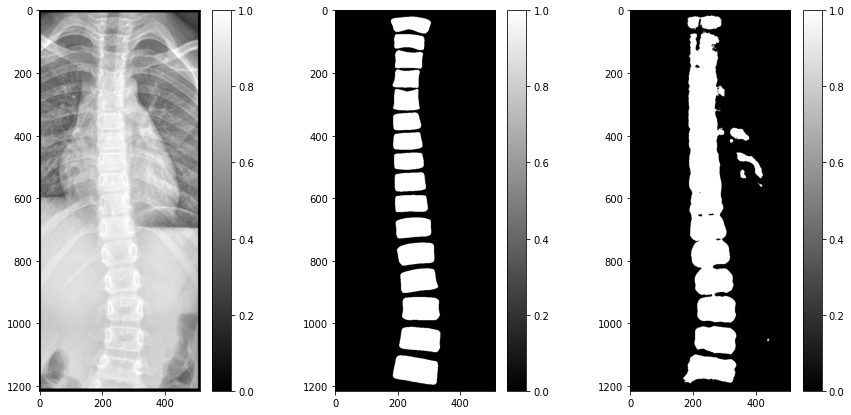

In [44]:
plt.figure(figsize=(15, 7))

#plot input img
plt.subplot(1, 3, 1)
plt.imshow(img.squeeze(0), cmap = 'gray')
plt.colorbar()

#plot label
plt.subplot(1, 3, 2)
plt.imshow(label.squeeze(0), cmap = 'gray')
plt.colorbar()

#plot pred
plt.subplot(1, 3, 3)
plt.imshow(pred.squeeze((0, 1)), cmap = 'gray')
plt.colorbar()


### Hook
可以取出模型內部output的東西

In [ ]:
'''
Pytorch包含forward以及backward兩種Hook，可用來取得forward和backward的輸入及輸出
好處是可不改變模型的任何架構以及不用在模型的forward或backward中寫一堆return，進而得到想要的數值
'''


def feature_map_hook(model, module, dataset, index):
  visualization = {}
  def hook_fn(m, i, o): # m: key, o: output
    visualization[m] = o.detach().cpu().numpy()

  # register hook after forward
  handler = module.register_forward_hook(hook_fn)

  model.eval()
  with torch.no_grad():
    img, label = dataset[index]
    pred = model(img.unsqueeze(0))

  #記得要把hook remove掉，否則會永遠存在在module的list裡 
  handler.remove()

  return visualization

#### High-level

In [ ]:
visualization = feature_map_hook(seg_model, seg_model.down5, valid_dataset, 11)

In [ ]:
feature_map = list(visualization.values())[0]
print(feature_map.shape)
feature_map = feature_map.squeeze(0)

In [ ]:
plt.figure(figsize=(20, 30))

for i in range(192):
  plt.subplot(12, 16, i + 1)
  plt.imshow(feature_map[i])

#### Low-level

In [ ]:
visualization = feature_map_hook(seg_model, seg_model.down1, valid_dataset, 11)

In [ ]:
feature_map = list(visualization.values())[0]
print(feature_map.shape)
feature_map = feature_map.squeeze(0)

In [ ]:
plt.figure(figsize=(15, 7))

for i in range(12):
  plt.subplot(2, 6, i + 1)
  plt.imshow(feature_map[i])

# Part6. Autograd Mechanism

In [ ]:
'''
幾乎每個DL framework都有自己的自動偏微分的engine。PyTorch中稱做Autograd。

權重的更新涉及兩個階段: Forward和Backward
'''

a = torch.randn((3,3), requires_grad = True)

w1 = torch.randn((3,3), requires_grad = True) # weight
w2 = torch.randn((3,3), requires_grad = True)
w3 = torch.randn((3,3), requires_grad = True)
w4 = torch.randn((3,3), requires_grad = True)

b = w1*a # 用手算的方式算出每個權重對loss的偏微分
c = w2*a

d = w3*b + w4*c 

L = (10 -d).sum()

L.backward()

# print('a.grad:{}\n'.format(a.grad))
# print('b.grad:{}'.format(b.grad))

### Computation Graphs

In [ ]:
'''
當model層數增加，參數變多時，手動計算每個weight對於loss的影響變得很不切實際。
為此PyTorch設計了一個資料結構:Computation Graphs(根據hook產生的有向無環圖)

!!!圖中的node是operator!!!
'''

#### Forward

![](https://blog.paperspace.com/content/images/2019/03/computation_graph.png)


#### Backward

![](https://blog.paperspace.com/content/images/2019/03/full_graph.png)


### What is requires_grad

In [ ]:
'''
顧名思義就是要設定哪些tensor需要計算gradient哪些不需要。->可以freeze模型某一部份使其不被更新
有幾點需要注意:
1.nn.Parameter是預設True。此外，一般create出來的Tensor預設是False。
2.requires_grad是會傳染的。 a*w2 = c => w2是true，則c必定是true，否則w2無法更改
3.如果一個tensor的requires_grad=True，那它會有一個attribute叫做grad_fn
4.如果一個tensor在Computation graph中是leaf，那麼他的grad_fn是None
5.通常leaf node(紫色)就是模型的parameter，是需要被update的。
'''


a = torch.randn((3,3), requires_grad = True)

w1 = torch.randn((3,3), requires_grad = True)
w2 = torch.randn((3,3), requires_grad = True)
w3 = torch.randn((3,3), requires_grad = True)
w4 = torch.randn((3,3), requires_grad = True)

b = w1*a 
c = w2*a

d = w3*b + w4*c 

L = 10 - d 

print("The grad fn for a is", a.grad_fn)
print("The grad fn for w1 is", w1.grad_fn)
print("The grad fn for c is", c.grad_fn) # c的偏微分
print("The grad fn for d is", d.grad_fn) # d的偏微分

### Pseudo code

In [ ]:
def backward (incoming_gradients): # 不斷迭代一直到所有node皆為leaf node為止
	self.Tensor.grad = incoming_gradients

	for inp in self.inputs: # 遍歷所有input
		if inp.grad_fn is not None: # 已經是leaf node
			new_incoming_gradients = incoming_gradient * local_grad(self.Tensor, inp)
			
			inp.grad_fn.backward(new_incoming_gradients)
		else:
			pass

# Homework

### 改良上面的Unet，使其3-fold平均Dice高於baseline

### 方向：


1.   加增模型深度或寬度 (v)
2.   改良encoder backbone。ex:ResNet, DenseNet, etc. 
3.   Unet換成Unet++ 
4.   加入Attention機制: Squeeze-and-Excitation Networks(可將非脊隨的noise壓制掉，放在convolution output後面)(v)
5.   利用Computer vision的演算法對預測做後處理



In [ ]:
class double_conv2(nn.Module):
    '''(conv-BN-ReLU)X2 :   in_ch  , out_ch , out_ch    '''
    def __init__(self, in_ch, out_ch):
        super(double_conv2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=2, dilation=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),  # True means cover the origin input
            nn.Conv2d(out_ch, out_ch, 3, padding=3, dilation=3),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        if 0:
            self.up = nn.Sequential(
                nn.ConvTranspose3d(in_ch * 2 // 3, in_ch * 2 // 3, kernel_size=2, stride=2, padding=0),
                nn.BatchNorm3d(in_ch * 2 // 3),
                nn.ReLU(inplace=True),
            )
        else:
            self.up = nn.Upsample(scale_factor=2)
        self.conv = double_conv2(in_ch, out_ch)

    def forward(self, x1, x2):  # x1--up , x2 ---down
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (
            diffY // 2, diffY - diffY // 2,
            diffX // 2, diffX - diffX // 2,))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class up3(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up3, self).__init__()
        if 0:
            self.up = nn.Sequential(
                nn.ConvTranspose3d(in_ch * 2 // 3, in_ch * 2 // 3, kernel_size=2, stride=2, padding=0),
                nn.BatchNorm3d(in_ch * 2 // 3),
                nn.ReLU(inplace=True),
            )
        else:
            self.up = nn.Upsample(scale_factor=2)
        self.conv = double_conv2(in_ch, out_ch)

    def forward(self, x1, x2, x3):
        # print(x1.shape)
        x1 = self.up(x1)
        x = torch.cat([x3, x2, x1], dim=1)
        x = self.conv(x)
        return x


class up4(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up4, self).__init__()
        if 0:
            self.up = nn.Sequential(
                nn.ConvTranspose3d(in_ch * 2 // 3, in_ch * 2 // 3, kernel_size=2, stride=2, padding=0),
                nn.BatchNorm3d(in_ch * 2 // 3),
                nn.ReLU(inplace=True),
            )
        else:
            self.up = nn.Upsample(scale_factor=2)
        self.conv = double_conv2(in_ch, out_ch)

    def forward(self, x1, x2, x3, x4):  # x1--up , x2 ---down
        # print(x1.shape)
        x1 = self.up(x1)
        x = torch.cat([x4, x3, x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.upsample = nn.Upsample(scale_factor=4)
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = F.sigmoid(x)
        return x


class double_conv(nn.Module):
    '''(conv-BN-ReLU)X2 :   in_ch  , in_ch , out_ch    '''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, padding=2, dilation=2),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),  # True means cover the origin input
            nn.Conv2d(in_ch, out_ch, 3, padding=3, dilation=3),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class double_conv_in(nn.Module):
    '''(conv-BN-ReLU)X2 :   in_ch  , in_ch , out_ch    '''

    def __init__(self, in_ch, out_ch):
        super(double_conv_in, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 5, padding=2),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),  # True means cover the origin input
            nn.Conv2d(in_ch, out_ch, 3, padding=1, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv_in(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


cc = 16  # you can change it to 8, then the model can be more faster ,reaching 35 fps on cpu when testing


class Unet_2D(nn.Module):
    def __init__(self, n_channels, n_classes, mode='train'):
        super(Unet_2D, self).__init__()
        self.inconv = inconv(n_channels, cc)
        self.down1 = down(cc, 2 * cc)
        self.down2 = down(2 * cc, 4 * cc)
        self.down3 = down(4 * cc, 8 * cc)
        self.up1 = up(12 * cc, 4 * cc)
        self.up20 = up(6 * cc, 2 * cc)
        self.up2 = up3(8 * cc, 2 * cc)
        self.up30 = up(3 * cc, cc)
        self.up31 = up3(4 * cc, cc)
        self.up3 = up4(5 * cc, cc)
        self.outconv = outconv(cc, n_classes)
        self.mode = mode

    def forward(self, x):
        if self.mode == 'train':  # use the whole model when training
            x1 = self.inconv(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x = self.up1(x4, x3)
            x21 = self.up20(x3, x2)
            x = self.up2(x, x21, x2)
            x11 = self.up30(x2, x1)
            x12 = self.up31(x21, x11, x1)
            x = self.up3(x, x12, x11, x1)
            #output 0 1 2
            y2 = self.outconv(x)
            y0 = self.outconv(x11)
            y1 = self.outconv(x12)
            return y0, y1, y2
        else:  # prune the model when testing
            x1 = self.inconv(x)
            x2 = self.down1(x1)
            x11 = self.up30(x2, x1)
            # output 0
            y0 = self.outconv(x11)
            return y0

In [ ]:
k_fold_best = [0] * kfold


for fold in range(kfold):

  (train_images, train_labels), (valid_images, valid_labels) = get_train_valid_data(fold)
  
  # 讀資料, loader
  train_dataset = AugmentedImageDataset(train_images, train_labels, get_complex_training_augmetation())
  valid_dataset = AugmentedImageDataset(valid_images, valid_labels, get_validation_augmentation())
  train_loader = DataLoader(train_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)
  valid_loader = DataLoader(valid_dataset, batch_size, shuffle, num_workers = num_workers, pin_memory = pin_memory)

  seg_model = Unet_2D(1, 1, 'test')
  opt = optimizer(seg_model.parameters(), lr = lr, weight_decay = weight_decay) # seg_model.parameters(): update model parameter, return learnable, trainable parameter

  seg_model.to(device)
  metric.to(device)

  model_name = os.path.join(save_path, str(fold+1), 'Unet.h5')

  max_score = 0

  # epoch: 把所有資料跑過一遍
  for epoch in range(epochs): # 每個fold會跑60個epoch
    print('Epoch: %d' %(epoch+1))

    #training phase
    seg_model.train() #!!!!非常重要!!!!
    
    train_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(train_loader, desc = 'Train', file = sys.stdout) as iterator: # 會跑training的進度條
      for imgs, gts in iterator:
        
        imgs = imgs.to(device, dtype = torch.float)# input記得要跟model在同一個device上，否則一個model在momery，另一個在gpu的memory是無法training的
        gts = gts.to(device, dtype = torch.float)
        preds = seg_model(imgs)
        loss = bce_loss(preds, gts)

        #計算gradient
        loss.backward()
        #根據gradient和lr等等更新網路權重
        opt.step()
        #記得清零，否則會保留上一個batch的grad
        opt.zero_grad()

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        train_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        train_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(train_logs))


    #validation phase
    seg_model.eval() #!!!!非常重要!!!!
    
    val_logs = {}
    loss_meter = AverageValueMeter()
    metric_meter = AverageValueMeter()
    with tqdm(valid_loader, desc = 'Valid', file = sys.stdout) as iterator:
      for imgs, gts in iterator:
        with torch.no_grad(): #!!!不算gradient!!! 沒寫其實也沒有關係，只是會不斷的累積gradient直到記憶體爆炸
        
          imgs = imgs.to(device, dtype = torch.float)
          gts = gts.to(device, dtype = torch.float)

          preds = seg_model(imgs)
          loss = bce_loss(preds, gts)

        loss_val = loss.cpu().detach().numpy()
        loss_meter.add(loss_val)
        val_logs.update({'CrossEntropy': loss_meter.mean})

        metric_val = metric(preds, gts).cpu().detach().numpy()
        metric_meter.add(metric_val)
        val_logs.update({metric.__name__: metric_meter.mean})

        iterator.set_postfix_str(to_string(val_logs))


    if max_score < val_logs['Dice']:
      max_score = val_logs['Dice'];
      k_fold_best[fold] = val_logs['Dice']

      torch.save(seg_model.state_dict(), model_name) # 前者model parameter(key: weight名稱。), 後者是存的地方
      print('Model Save !!!!')

print('\n')
print('K-Fold average Dice : %0.4f' %(sum(k_fold_best) / len(k_fold_best)))

